# Загрузка данных

In [169]:
# from google.colab import files

In [170]:
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [171]:
# !kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

In [172]:
# !unzip health-insurance-cross-sell-prediction.zip

# Описание данных

**Задача**  
Компания, предоставляющая медицинскую страховку, хочет спрогнозировать, будут ли её клиенты, уже имевшие медицинскую страховку в прошлом году, заинтересованы в автостраховке.  
Цель задачи — оптимизировать стратегию взаимодействия с клиентами и увеличить доход компании.

**Данные**  
Для построения модели предоставлен набор данных, содержащий информацию о клиентах. Включены демографические данные, информация о транспортных средствах, характеристиках полиса и поведении клиентов.

**Структура данных**  

| Поле                   | Описание                                                                                   |
|------------------------|-------------------------------------------------------------------------------------------|
| **id**                | Уникальный идентификатор клиента                                                           |
| **Gender**            | Пол клиента                                                                                |
| **Age**               | Возраст клиента                                                                            |
| **Driving_License**   | Наличие водительских прав: <br> `0` — клиент не имеет водительских прав <br> `1` — имеет    |
| **Region_Code**       | Уникальный код региона клиента                                                             |
| **Previously_Insured**| Наличие автостраховки: <br> `1` — клиент уже имеет автостраховку <br> `0` — не имеет        |
| **Vehicle_Age**       | Возраст автомобиля                                                                         |
| **Vehicle_Damage**    | История повреждений автомобиля: <br> `1` — были повреждения <br> `0` — не было              |
| **Annual_Premium**    | Годовая премия, которую клиент должен заплатить за страховку                               |
| **Policy_Sales_Channel** | Код канала продаж (анонимизирован): агенты, почта, телефон, личный визит и т.д.          |
| **Vintage**           | Количество дней, которые клиент состоит в компании                                         |
| **Response**          | Целевой признак: <br> `1` — клиент заинтересован <br> `0` — не заинтересован               |


# Импорты библиотек

In [173]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
from phik import report, resources
from phik.report import plot_correlation_matrix
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro
from scipy.stats.contingency import relative_risk
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

# Константы

In [174]:
N_THREADS = 1
N_FOLDS = 5
RANDOM_STATE = 101
TEST_SIZE = 0.25
TARGET_NAME = "Response"

# Анализ данных

In [175]:
train = pd.read_csv("train.csv")

In [176]:
data = train.copy()
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Можем заметить, что пропусков в наборе данных нет.

Выделим тестовый набор данных.


In [178]:
df, test_df = train_test_split(
    data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data[TARGET_NAME]
)

In [179]:
df = df.drop("id", axis=1)

Рассмотрим количество уникальных значений в каждом признаке.

In [180]:
df.T.nunique(axis=1)

Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          45656
Policy_Sales_Channel      153
Vintage                   290
Response                    2
dtype: int64

Выделим числовые и категориальные признаки.

In [181]:
num_columns = ["Age", "Annual_Premium", "Vintage"]
cat_columns = [
    "Gender",
    "Driving_License",
    "Region_Code",
    "Previously_Insured",
    "Vehicle_Age",
    "Vehicle_Damage",
    "Policy_Sales_Channel",
]

In [182]:
df[cat_columns] = df[cat_columns].astype("object")

Статистики числовых признаков:

In [183]:
df[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,285831.0,38.821741,15.512977,20.0,25.0,36.0,49.0,85.0
Annual_Premium,285831.0,30596.844104,17327.426641,2630.0,24431.0,31680.0,39417.0,540165.0
Vintage,285831.0,154.368550,83.686845,10.0,82.0,154.0,227.0,299.0


Наблюдаем, что существуют уникальные клиенты, у которых потенциальная стоимость страховки достаточно велика, у 75% не более 40000 рупий, максимальная - 540165 рупий.

Статистики категориальных признаков:

In [184]:
cat_columns_stats = df[cat_columns].describe().T
cat_columns_stats["freq_normalize"] = cat_columns_stats["freq"] / df.shape[0]
cat_columns_stats

,count,unique,top,freq,freq_normalize
Gender,285831,2,Male,154426,0.54027
Driving_License,285831,2,1,285218,0.997855
Region_Code,285831.0,53.0,28.0,79765.0,0.279064
Previously_Insured,285831,2,0,154966,0.54216
Vehicle_Age,285831,3,1-2 Year,150160,0.525345
Vehicle_Damage,285831,2,Yes,144358,0.505047
Policy_Sales_Channel,285831.0,153.0,152.0,101166.0,0.353936


Среди клиентов большая часть (54%) - мужчины.  
Почти все клиенты имеют водительские права.  
Регионы несбалансированы.  
Большая часть клиентов (54%) не имеют автостраховки.  
Большинство клиентов имеют автомобиль возрастом 1-2 года.  
Около 50% клиентов имеют автомобиль, который попадал в ДТП.  
Каналы продаж так же несбалансированы.

# Проверка наличия выбросов

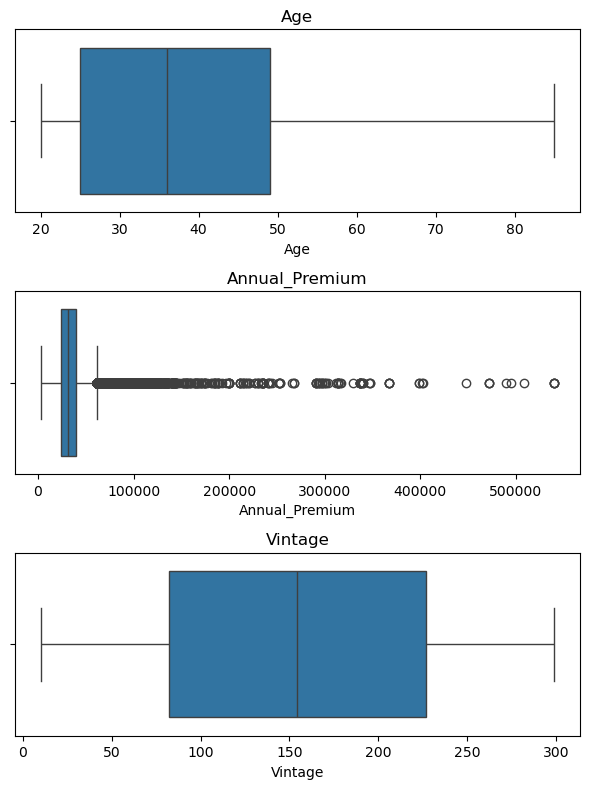

In [185]:
fig, axes = plt.subplots(nrows=len(num_columns), figsize=(6, 8))

for i, col in enumerate(num_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()

Для признака ***Annual_Premium*** наблюдается несколько очень больших по величине значений.  
Посмотрим на максимальные и минимальные значения, а также определим: какую долю составляют клиенты с выделяющимися значениями ***Annual_Premium***.

In [186]:
df["Annual_Premium"].agg(["min", "max"])

min      2630.0
max    540165.0
Name: Annual_Premium, dtype: float64

In [187]:
def search_outliers(feature):
    """Функция принимает набор значений 1-го признака и
    возвращает массив индексов тех значений, которые являются выбросами"""
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.where((feature < lower_bound) | (feature > upper_bound))[0]

In [188]:
outliers = search_outliers(df["Annual_Premium"])

In [189]:
outliers_prop = (outliers.shape[0] / df.shape[0]) * 100
outliers_prop

2.687951971619593

На данном этапе получаем, что максимальное значение ***Annual_Premium*** составляет 540165 рупий. Курс рубля к рупиям: 1/0.82. Таким образом в рублях максимальное значение ***Annual_Premium*** составит около 655000 рублей. В целом, для достаточно дорогих автомобилей размер платы за страховку в 655 т.руб. можно считать адекватным.

# EDA

Посмотрим на соотношение классов целевой переменной

In [190]:
df[TARGET_NAME].value_counts(normalize=True)

Response
0    0.877438
1    0.122562
Name: proportion, dtype: float64

Значения целевой переменной несбалансированы, преобладает класс незаинтересованых клиентов.

Далее проверим гипотезы:
- для категориальных признаков:  
различия в долях клиентов купивших страховку между категориями не значимые;
  
- для числовых:  
изменение значения признака не влияет на покупку страховки.


## Анализ числовых признаков

Рассмотрим следующие признаки:

In [191]:
num_columns

['Age', 'Annual_Premium', 'Vintage']

### Возраст клиента (*Age*)

Проверим, а значимо ли отличаются средние значения возраста среди клиентов купивших страховку и клиентов, которые воздержались.

Text(0.5, 1.0, 'Средние значения возраста среди клиентов, купивших страховку, и клиентов, которые воздержались')

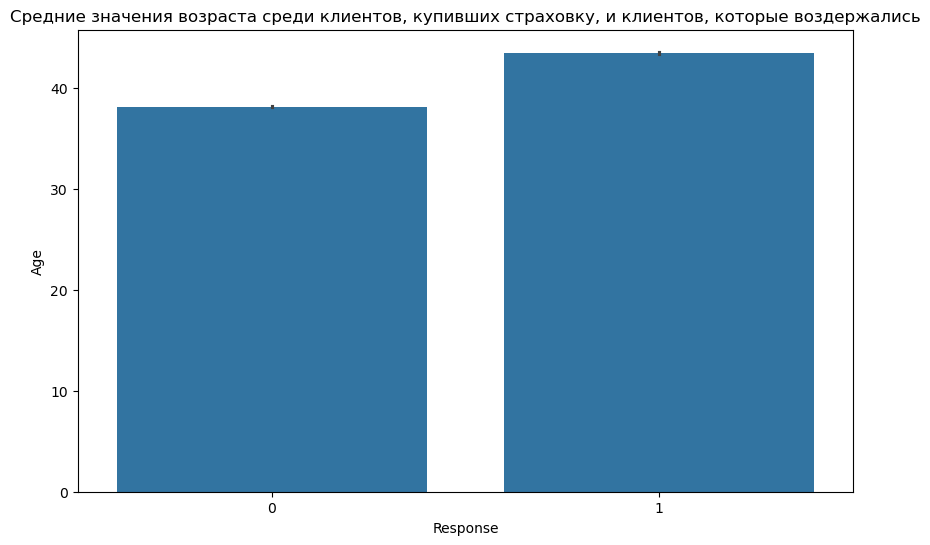

In [192]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, y="Age", x=TARGET_NAME).set_title(
    "Средние значения возраста среди клиентов, "
    "купивших страховку, и клиентов, которые воздержались"
)

График выше демонстрирует, что увеличение возраста повышает склонность к покупке страховки.

In [193]:
df.groupby(TARGET_NAME)["Age"].mean()

Response
0    38.171887
1    43.474138
Name: Age, dtype: float64

Дополнительно убедимся при помощи статистических тестов.

Посмотрим на распределение признака.

Text(0.5, 1.0, 'Распределения возрастов клиентов')

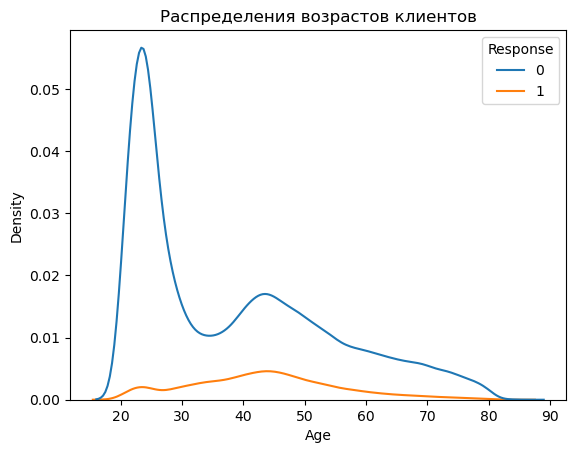

In [194]:
sns.kdeplot(data=df, x="Age", hue=TARGET_NAME).set_title(
    "Распределения возрастов клиентов"
)

Распределение возрастов клиентов далеко от нормального.  
Поэтому для сравнения средних воспользуемся критерием Манна — Уитни.

In [195]:
stat, p = mannwhitneyu(
    df.loc[df[TARGET_NAME] == 1, "Age"], df.loc[~(df[TARGET_NAME] == 1), "Age"]
)
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=5513559836.500, p=0.000


Так `p-value` << 0.05, то гипотезу о том, что возраст не влияет на покупку страховки уверенно отвергаем.

### Стоимость страховки (*Annual_Premium*)

Text(0.5, 1.0, 'Средние значения стоимости страховки среди клиентов, купивших страховку, и клиентов, которые воздержались')

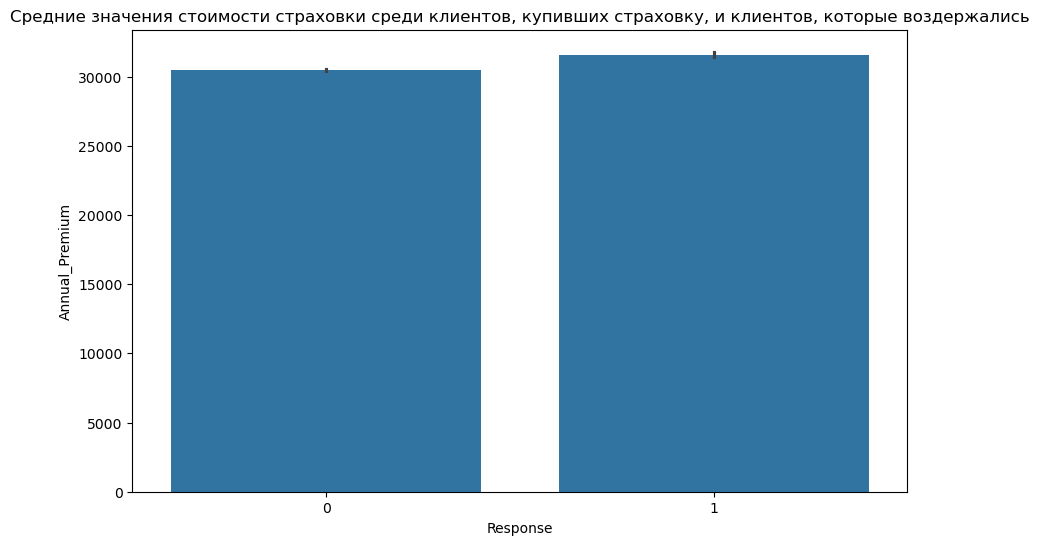

In [196]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, y="Annual_Premium", x=TARGET_NAME).set_title(
    "Средние значения стоимости страховки среди клиентов, "
    "купивших страховку, и клиентов, которые воздержались"
)

В данном случае средние довольно близки.

Text(0.5, 1.0, 'Распределения стоимостей страховок')

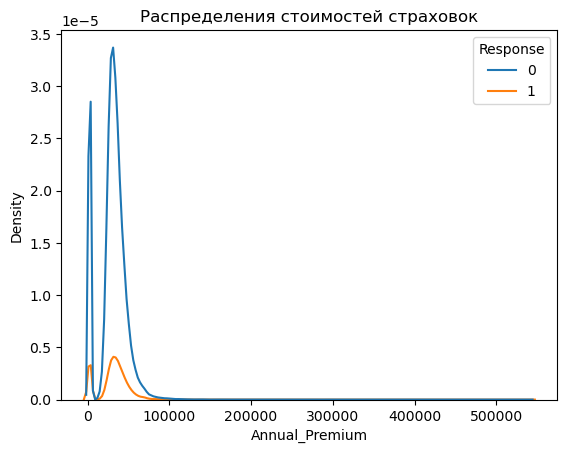

In [197]:
sns.kdeplot(data=df, x="Annual_Premium", hue=TARGET_NAME).set_title(
    "Распределения стоимостей страховок"
)

Распределения снова далеки от нормальных, воспользуемся тем же тестом Манна — Уитни.

In [198]:
stat, p = mannwhitneyu(
    df.loc[df[TARGET_NAME] == 1, "Annual_Premium"],
    df.loc[~(df[TARGET_NAME] == 1), "Annual_Premium"],
)
print("Statistics=%.3f, p=%.10f" % (stat, p))

Statistics=4648481398.000, p=0.0000000000


`p-value` << 0.05, следовательно, увеличение стоимости страховки так же влияет на покупку страховки.

Это можно интрепретировать следующим образом, если у клиента дорогой авто (выше стоимость страховки), то он вероятнее купит страховку, чем тот у кого авто подешевле.

### Количество дней сотрудничества с компанией (*Vintage*)

Text(0.5, 1.0, 'Средние кол-ва дней сотрудничества среди клиентов, купивших страховку, и клиентов, которые воздержались')

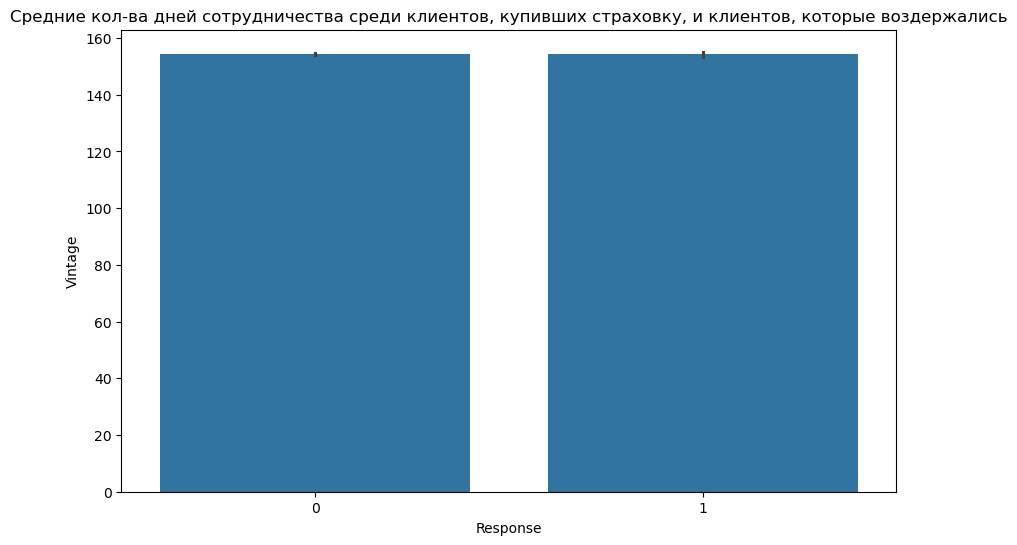

In [199]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, y="Vintage", x=TARGET_NAME).set_title(
    "Средние кол-ва дней сотрудничества среди клиентов, "
    "купивших страховку, и клиентов, которые воздержались"
)

Отличия в средних еще менее заметны.

Тут без тестов точно не обойтись.

Text(0.5, 1.0, 'Распределения количества дней сотрудничества')

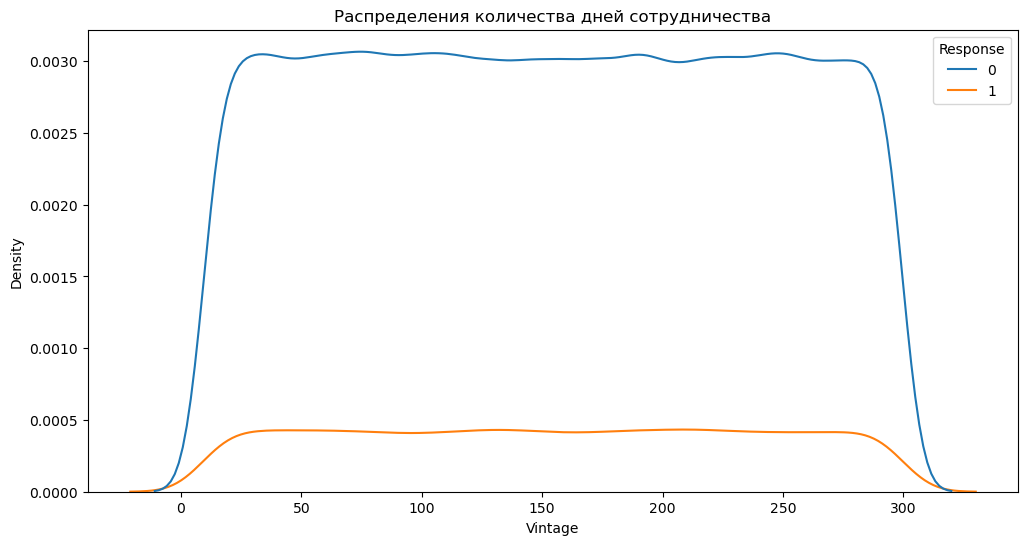

In [200]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Vintage", hue=TARGET_NAME).set_title(
    "Распределения количества дней сотрудничества"
)

In [201]:
shapiro_test_1 = shapiro(df.loc[df[TARGET_NAME] == 1, "Vintage"])
shapiro_test_0 = shapiro(df.loc[df[TARGET_NAME] == 1, "Vintage"])

print(shapiro_test_1)
print(shapiro_test_0)

ShapiroResult(statistic=0.9548217406164785, pvalue=4.8873877772693e-71)
ShapiroResult(statistic=0.9548217406164785, pvalue=4.8873877772693e-71)


Согласно результатам теста Шапиро — Уилка, распределения выборок существенно отличаются от нормальных.

Применяем тот же тест Манна — Уитни.

In [202]:
stat, p = mannwhitneyu(
    df.loc[df[TARGET_NAME] == 1, "Vintage"], df.loc[~(df[TARGET_NAME] == 1), "Vintage"]
)
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=4389965945.500, p=0.834


В данном случае получаем, что изменение количества дней сотрудничества не оказывает влияния на покупку страховки.

## Анализ категориальных признаков

In [203]:
cat_columns

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

### Пол (*Gender*)

Text(0, 0.5, 'Доля клиентов купивших страховку')

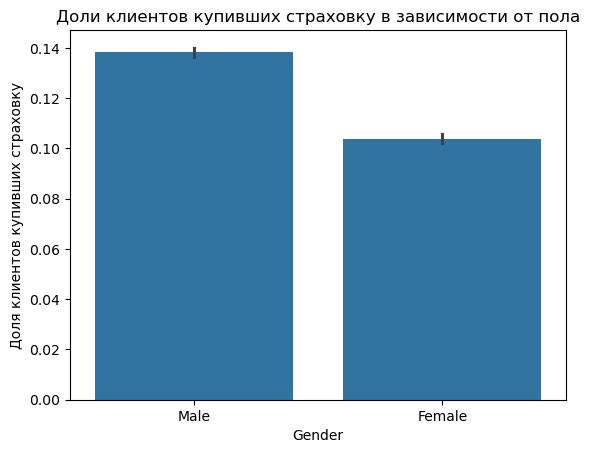

In [204]:
sns.barplot(data=df, x="Gender", y=TARGET_NAME).set_title(
    "Доли клиентов купивших страховку в зависимости от пола"
)
plt.ylabel("Доля клиентов купивших страховку")

Мужчины более склонны к покупке страховки.

### Наличие прав (*Driving_License*)

Text(0, 0.5, 'Доля клиентов купивших страховку')

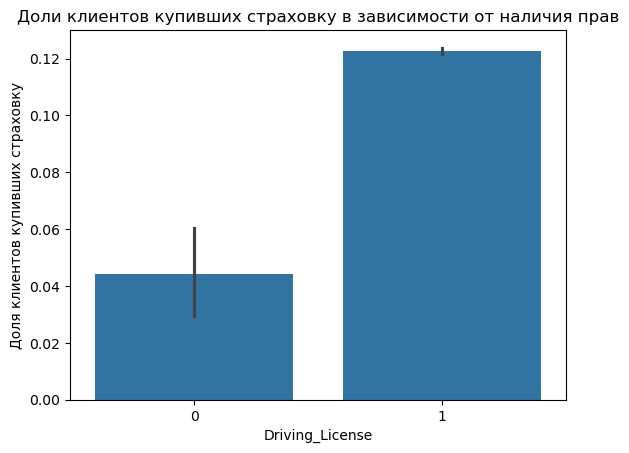

In [205]:
sns.barplot(data=df, x="Driving_License", y=TARGET_NAME).set_title(
    "Доли клиентов купивших страховку в зависимости от наличия прав"
)
plt.ylabel("Доля клиентов купивших страховку")

Клиенты с правами более склонны к покупке страховки.

### Регион (*Region_Code*)

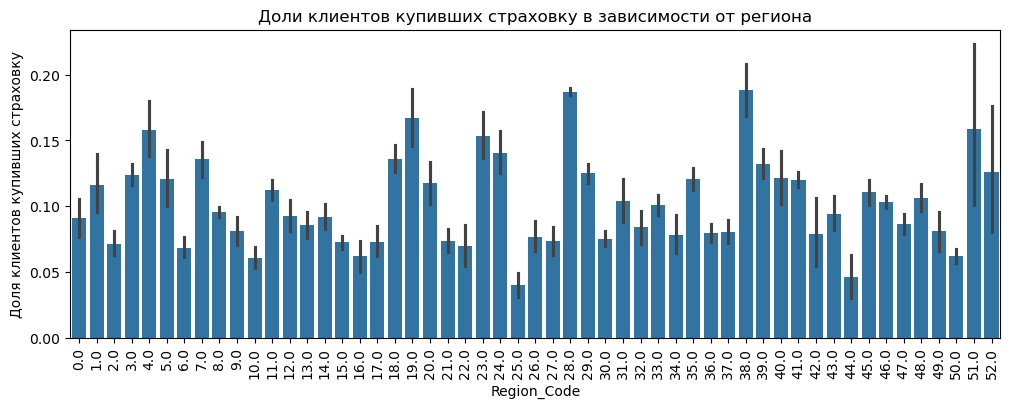

In [206]:
plt.figure(figsize=(12, 4))
sns.barplot(data=df, x="Region_Code", y=TARGET_NAME).set_title(
    "Доли клиентов купивших страховку в зависимости от региона"
)
plt.ylabel("Доля клиентов купивших страховку")
plt.xticks(rotation="vertical");

Между отдельными регионами наблюдаются значимые различия.

### Наличие дтп (*Vehicle_Damage*)

In [207]:
df.groupby("Vehicle_Damage")[TARGET_NAME].value_counts(normalize=True)

Vehicle_Damage  Response
No              0           0.995003
                1           0.004997
Yes             0           0.762223
                1           0.237777
Name: proportion, dtype: float64

После агрегации появляется намек на то, что клиенты с пострадавшими в дтп авто более склонны покупать страховку.  
Убедимся в этом.

Text(0, 0.5, 'Доля клиентов купивших страховку')

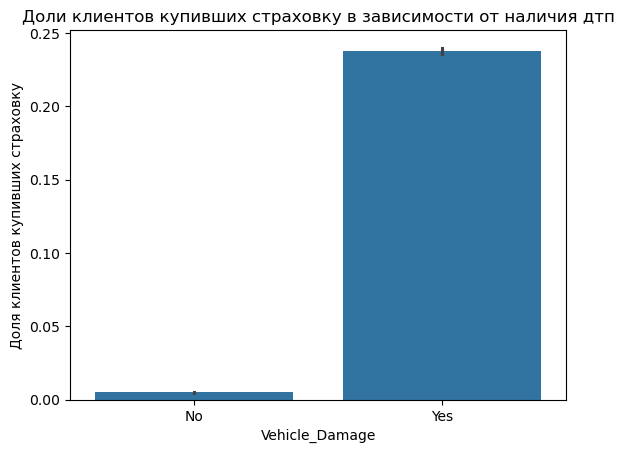

In [208]:
sns.barplot(data=df, x="Vehicle_Damage", y=TARGET_NAME).set_title(
    "Доли клиентов купивших страховку в зависимости от наличия дтп"
)
plt.ylabel("Доля клиентов купивших страховку")

Действительно, авто после дтп побужает клиента купить страховку.

### Наличие ранее купленной страховки (*Previously_Insured*)

In [209]:
df.groupby("Previously_Insured")[TARGET_NAME].value_counts(normalize=True)

Previously_Insured  Response
0                   0           0.774686
                    1           0.225314
1                   0           0.999114
                    1           0.000886
Name: proportion, dtype: float64

Доверимся агрегации. Клиенты без страховки более склоны к ее покупке.

### Возраст авто (*Vehicle_Age*)

In [210]:
df.groupby("Vehicle_Age")[TARGET_NAME].value_counts(normalize=True)

Vehicle_Age  Response
1-2 Year     0           0.826299
             1           0.173701
< 1 Year     0           0.956576
             1           0.043424
> 2 Years    0           0.704315
             1           0.295685
Name: proportion, dtype: float64

Клиенты, c авто старше 1 года более склонны к покупке страховки.

### Канал продаж (*Policy_Sales_Channel*)

In [211]:
df.Policy_Sales_Channel.nunique()

153

Text(0.5, 0, 'Доля клиентов купивших страховку')

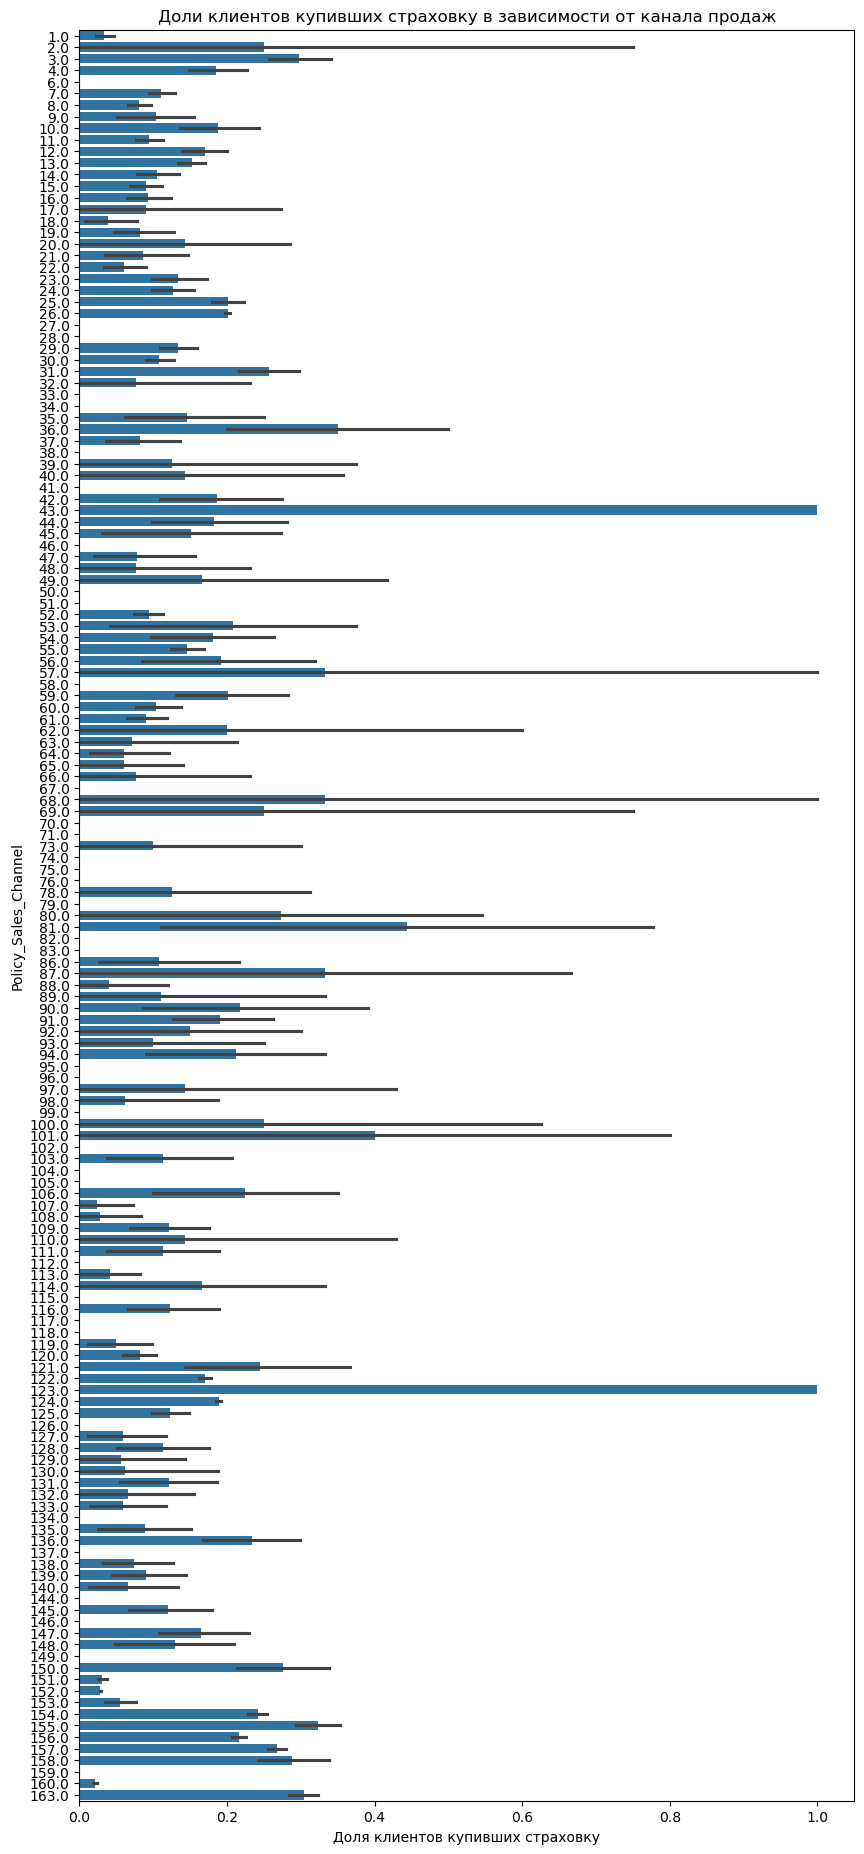

In [212]:
plt.figure(figsize=(10, 23))
sns.barplot(data=df, y="Policy_Sales_Channel", x=TARGET_NAME, orient="h").set_title(
    "Доли клиентов купивших страховку в зависимости от канала продаж"
)
plt.xlabel("Доля клиентов купивших страховку")

Между отдельными каналами видны значимые различия, но в целом, данный признак не особо информативен.

## Зависимости между признаками и целевой переменной

Посмотрим на зависимости между признаками и целевой переменной.

In [213]:
df.drop(columns=["Region_Code", "Policy_Sales_Channel"]).phik_matrix(
    interval_cols=num_columns
).style.background_gradient(cmap="coolwarm")

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
Gender,1.000000,0.225027,0.029482,0.129895,0.100804,0.143868,0.017323,0.005933,0.082366
Age,0.225027,1.000000,0.128790,0.445297,0.778711,0.452520,0.106803,0.000000,0.299752
Driving_License,0.029482,0.128790,1.000000,0.022977,0.024241,0.024272,0.013172,0.000000,0.017002
Previously_Insured,0.129895,0.445297,0.022977,1.000000,0.234131,0.962340,0.051711,0.008080,0.510327
Vehicle_Age,0.100804,0.778711,0.024241,0.234131,1.000000,0.244305,0.104337,0.000000,0.135052
Vehicle_Damage,0.143868,0.452520,0.024272,0.962340,0.244305,1.000000,0.054195,0.010239,0.529026
Annual_Premium,0.017323,0.106803,0.013172,0.051711,0.104337,0.054195,1.000000,0.009777,0.030100
Vintage,0.005933,0.000000,0.000000,0.008080,0.000000,0.010239,0.009777,1.000000,0.002170
Response,0.082366,0.299752,0.017002,0.510327,0.135052,0.529026,0.030100,0.002170,1.000000


Наблюдаем достаточно сильную зависимость между признаками *Previously_Insured* (Наличие автостраховки) и  *Vehicle_Damage* (Бывал ли авто в ДТП).  
Если авто поврежденный, то вероятно предыдущая страховка у клиента будет отсутствовать.  
И наоборот, если авто без повреждений, то у клиента вероятно будет страховка.

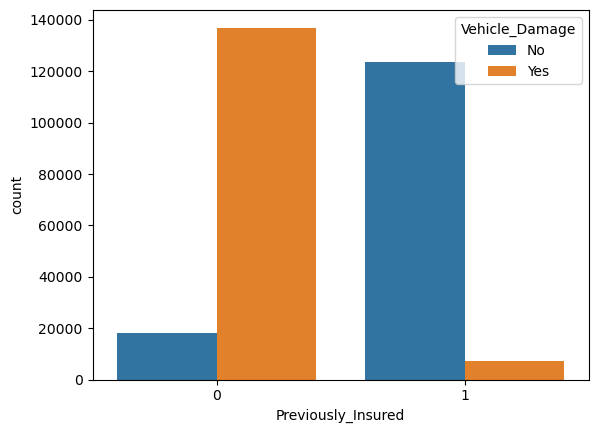

In [214]:
sns.countplot(x="Previously_Insured", hue="Vehicle_Damage", data=df)
plt.show()

Так как на основании одного из данных признаков можно с достаточно большой вероятностью предсказать другой,  
избавимся от одного из признаков, например, от *Previously_Insured*.

In [215]:
df = df.drop(columns="Previously_Insured")

In [216]:
df.drop(columns=["Region_Code", "Policy_Sales_Channel"]).phik_matrix(
    interval_cols=num_columns
).style.background_gradient(cmap="coolwarm")

,Gender,Age,Driving_License,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
Gender,1.000000,0.225027,0.029482,0.100804,0.143868,0.017323,0.005933,0.082366
Age,0.225027,1.000000,0.128790,0.778711,0.452520,0.106803,0.000000,0.299752
Driving_License,0.029482,0.128790,1.000000,0.024241,0.024272,0.013172,0.000000,0.017002
Vehicle_Age,0.100804,0.778711,0.024241,1.000000,0.244305,0.104337,0.000000,0.135052
Vehicle_Damage,0.143868,0.452520,0.024272,0.244305,1.000000,0.054195,0.010239,0.529026
Annual_Premium,0.017323,0.106803,0.013172,0.104337,0.054195,1.000000,0.009777,0.030100
Vintage,0.005933,0.000000,0.000000,0.000000,0.010239,0.009777,1.000000,0.002170
Response,0.082366,0.299752,0.017002,0.135052,0.529026,0.030100,0.002170,1.000000


Подтверждается неинформативность признаков *Driving_License* и *Vintage*, удалим их.

In [217]:
df = df.drop(columns=["Driving_License", "Vintage"])

In [218]:
df.drop(columns=["Region_Code", "Policy_Sales_Channel"]).phik_matrix(
    interval_cols=num_columns
).style.background_gradient(cmap="coolwarm")

,Gender,Age,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response
Gender,1.000000,0.225027,0.100804,0.143868,0.017323,0.082366
Age,0.225027,1.000000,0.778711,0.452520,0.106803,0.299752
Vehicle_Age,0.100804,0.778711,1.000000,0.244305,0.104337,0.135052
Vehicle_Damage,0.143868,0.452520,0.244305,1.000000,0.054195,0.529026
Annual_Premium,0.017323,0.106803,0.104337,0.054195,1.000000,0.030100
Response,0.082366,0.299752,0.135052,0.529026,0.030100,1.000000


Снова наблюдаем важность признака *Vehicle_Damage* в склонности к покупке страховки.

Подмечаем, что молодые люди склонны ездить на более свежих автомобилях.

Text(0.5, 1.0, 'Средние значения возраста в зависимости от возраста авто')

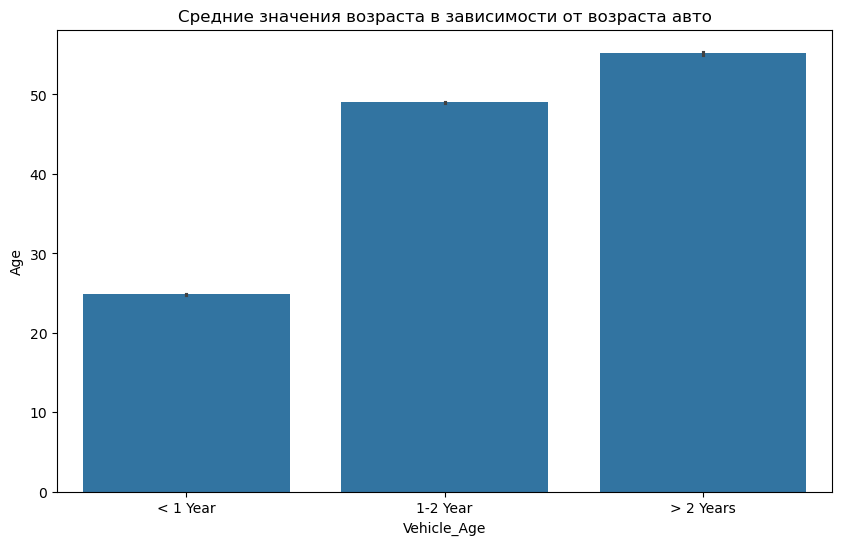

In [219]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, y="Age", x="Vehicle_Age").set_title(
    "Средние значения возраста в зависимости от возраста авто"
)

#  Feature engineering

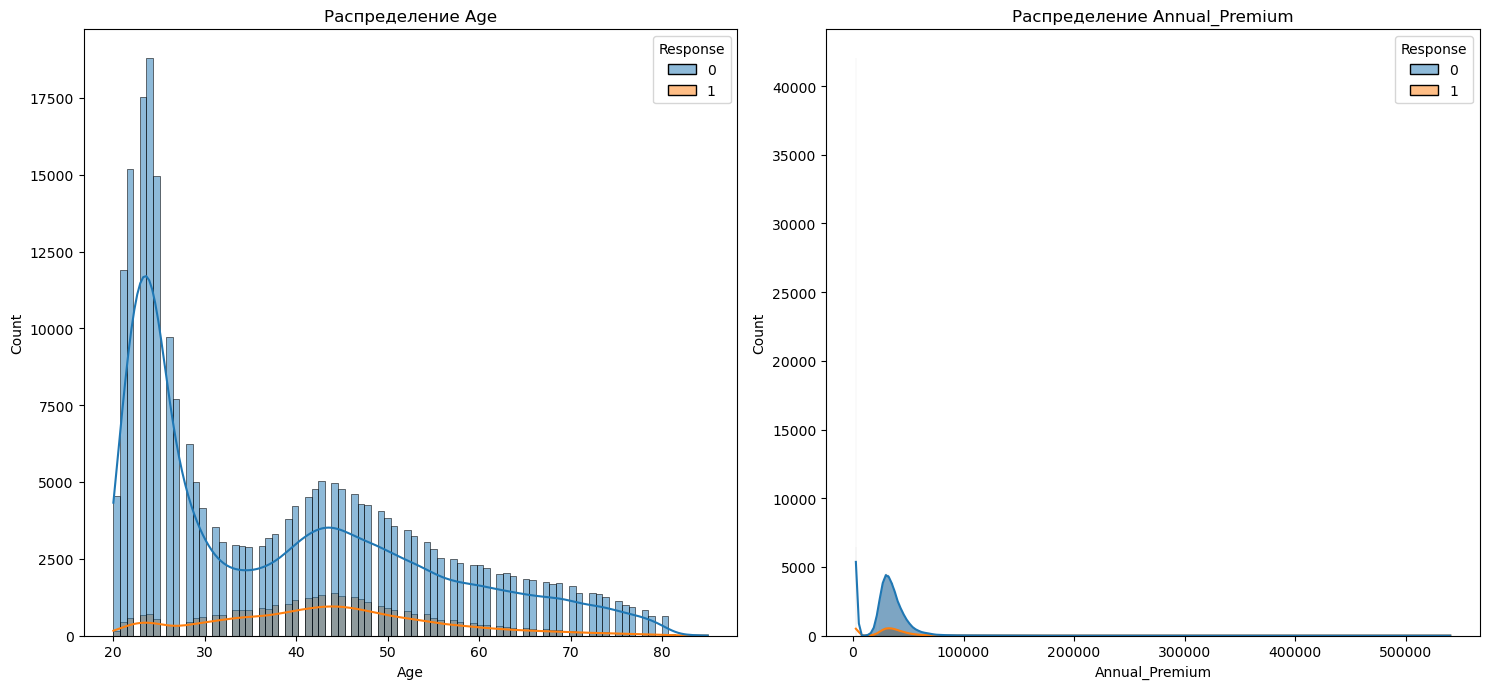

In [220]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, feature in enumerate(["Age", "Annual_Premium"]):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i], hue=TARGET_NAME)
    axes[i].set_title(f"Распределение {feature}")


plt.tight_layout()

Глядя на распределение возрастов клиентов, можно заметить еще одну интересную особенность, клиенты до 30 лет менее склонны к покупке страховки, чем клиенты постарше.  
Это подтверждает следующий факт: в распределении возрастов клиентов, купивших страховку, не наблюдается пика в диапазоне от 20 до 30 лет.

Дискретируем признак *Age*, выберем число интервалов равным 12.

In [221]:
est = KBinsDiscretizer(n_bins=12, encode="ordinal", strategy="quantile")

df["Age_discretized"] = est.fit_transform(df[["Age"]])

In [222]:
df["Age_discretized"].value_counts()

Age_discretized
2.0     37663
4.0     30351
9.0     26059
11.0    25293
10.0    24743
7.0     24447
5.0     23897
8.0     22769
6.0     22327
0.0     17011
1.0     15782
3.0     15489
Name: count, dtype: int64

Интервалы по количеству наблюдений достаточно сбалансированы.

In [223]:
df[["Age", "Age_discretized", TARGET_NAME]].phik_matrix(
    interval_cols=num_columns
).style.background_gradient(cmap="coolwarm")

,Age,Age_discretized,Response
Age,1.000000,0.904768,0.299752
Age_discretized,0.904768,1.000000,0.297695
Response,0.299752,0.297695,1.000000


Новый признак Age_discretized имеет схожий уровень зависимости с целевой переменной, изначальный признак *Age* удалим.

In [224]:
df["Age"] = df["Age_discretized"]
df.drop(columns="Age_discretized", inplace=True)

Признак *Annual_Premium* преобразуем в бинарный, разделим по значению 10000.

(0.0, 100000.0)

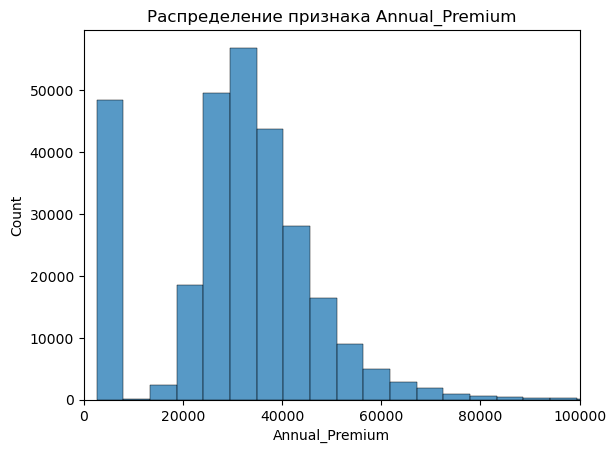

In [225]:
sns.histplot(data=df, x="Annual_Premium", bins=100).set_title(
    "Распределение признака Annual_Premium"
)
plt.xlim(0, 1e5)

In [226]:
df["Annual_Premium"] = Binarizer(threshold=1e4).fit_transform(df[["Annual_Premium"]])

Рассмотрим категориальные признаки.

In [227]:
cat_columns = df.drop(columns=["Annual_Premium", "Age", TARGET_NAME]).columns

In [228]:
cat_columns

Index(['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage',
       'Policy_Sales_Channel'],
      dtype='object')

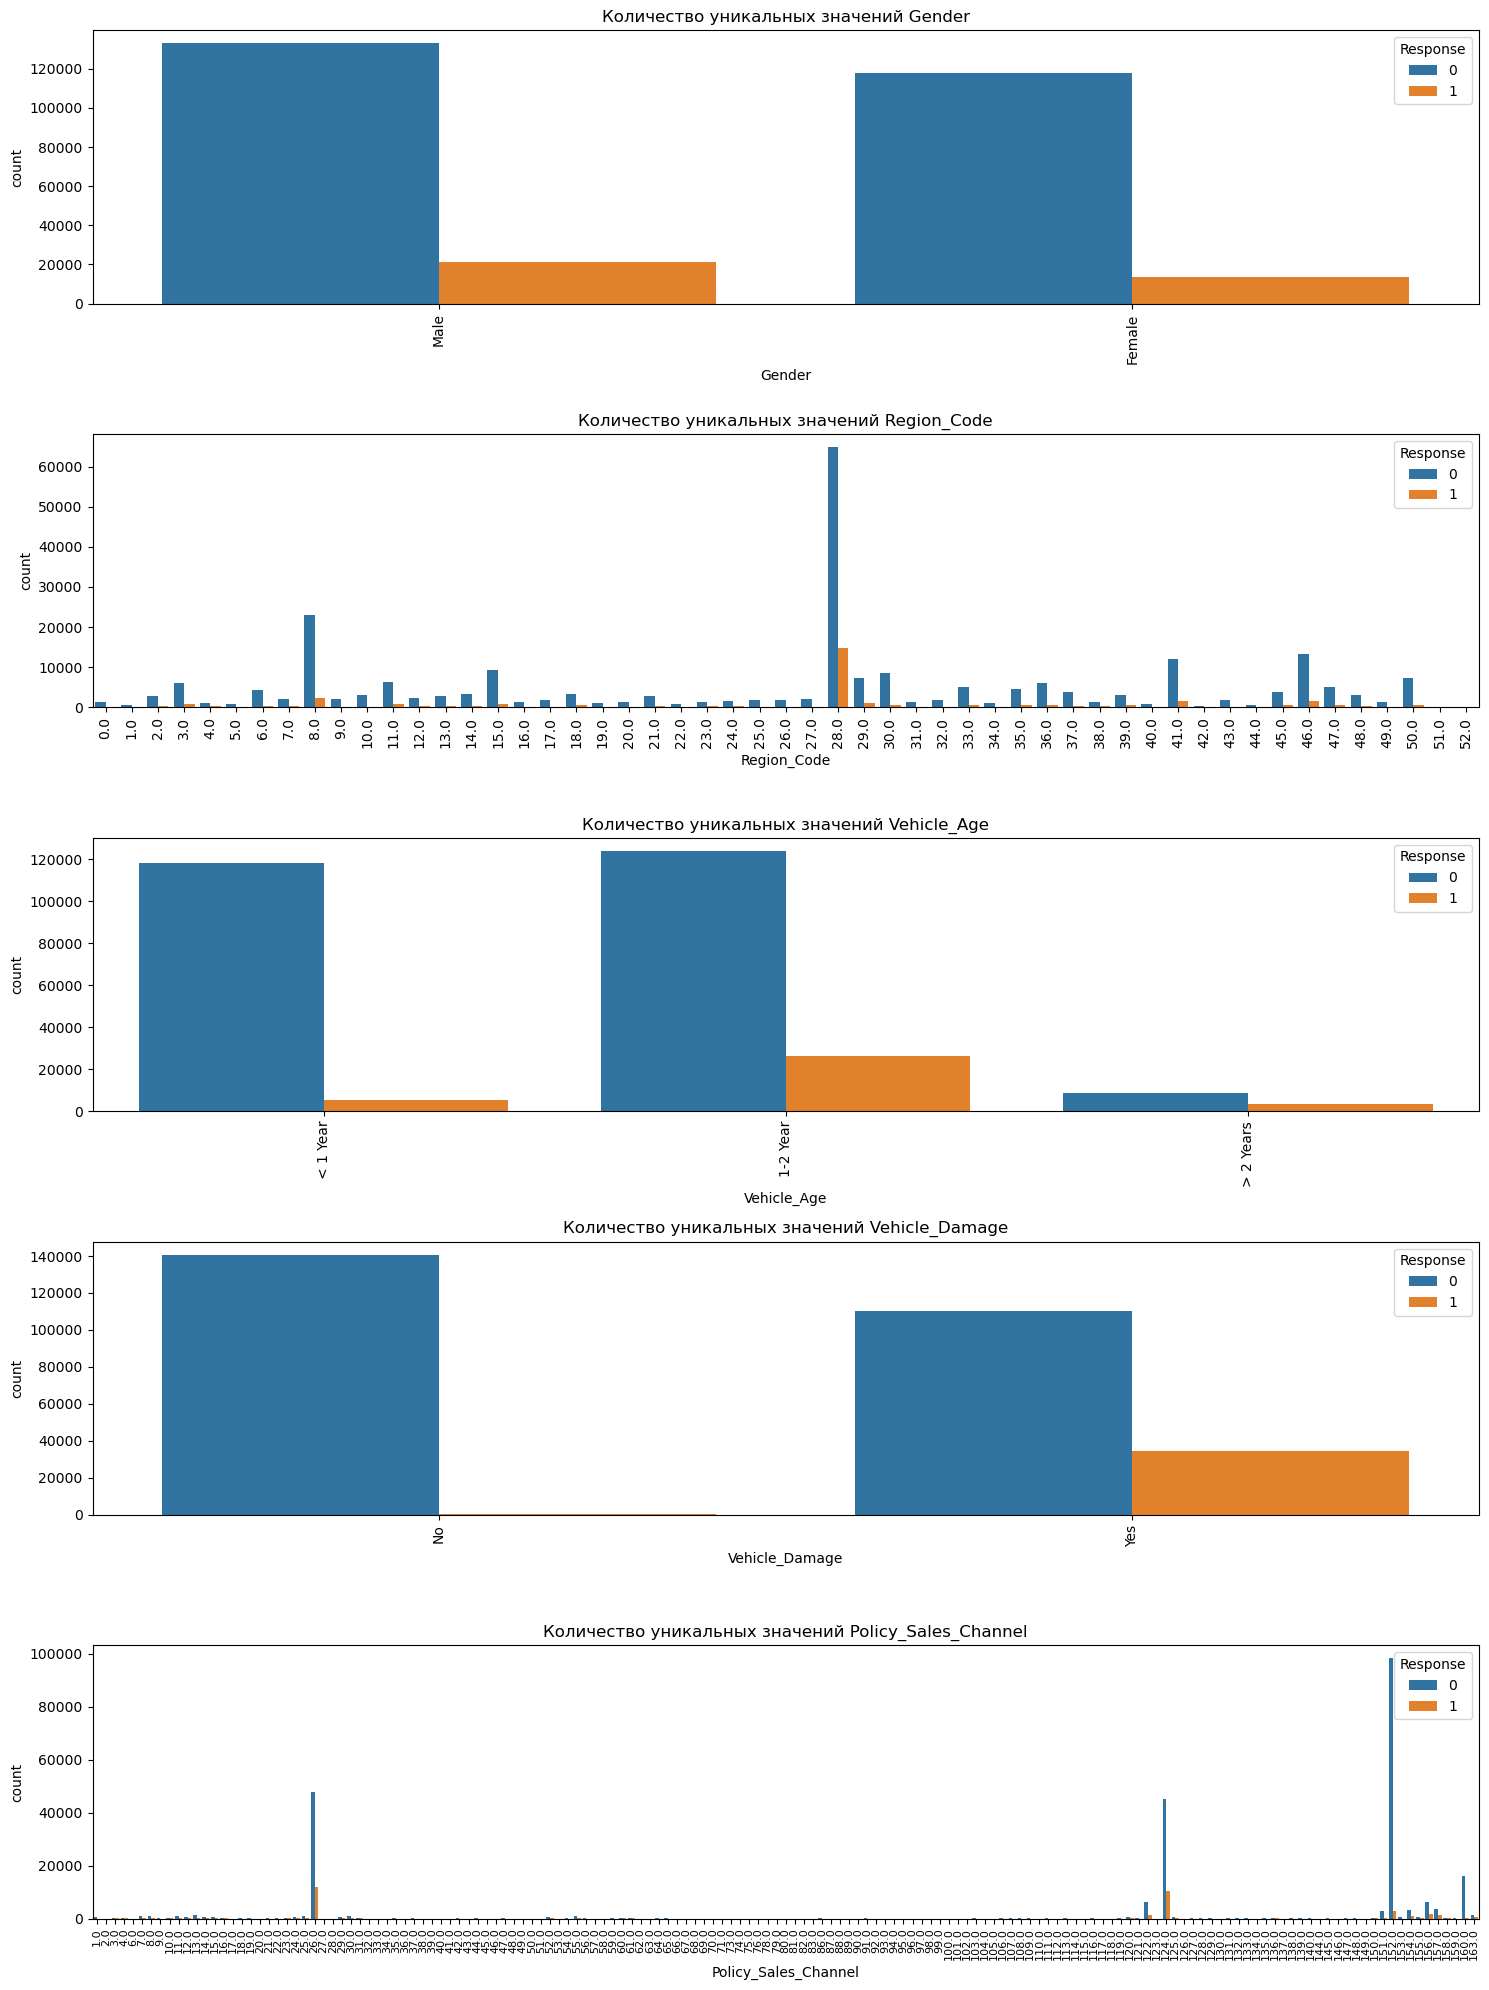

In [229]:
fig, axes = plt.subplots(len(cat_columns), 1, figsize=(15, 20))

for i, feature in enumerate(cat_columns):
    sns.countplot(data=df, x=feature, hue=TARGET_NAME, ax=axes[i])
    axes[i].set_title(f"Количество уникальных значений {feature}")
    if feature == "Policy_Sales_Channel":
        axes[i].set_xticklabels(
            axes[i].get_xticklabels(), rotation="vertical", fontsize=8
        )
    else:
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation="vertical")

plt.tight_layout()

Что касается признака *Region_Code*, то количества наблюдений в категориях довольно несбалансированы.  
Присутствует преобладающий регион с кодом 28.

In [230]:
df["Region_Code"].value_counts(normalize=True)

Region_Code
28.0    0.279064
8.0     0.088794
46.0    0.051548
41.0    0.047783
15.0    0.035189
30.0    0.032313
29.0    0.028989
50.0    0.027005
11.0    0.024574
3.0     0.024238
36.0    0.022828
33.0    0.020001
47.0    0.019442
35.0    0.018098
6.0     0.016573
45.0    0.014851
37.0    0.014197
18.0    0.013539
14.0    0.012406
48.0    0.012364
39.0    0.012228
10.0    0.011307
21.0    0.011118
2.0     0.010671
13.0    0.010608
7.0     0.008781
12.0    0.008641
9.0     0.008316
27.0    0.007396
32.0    0.007221
43.0    0.006910
26.0    0.006885
17.0    0.006871
25.0    0.006528
24.0    0.006276
0.0     0.005332
38.0    0.005265
23.0    0.005171
16.0    0.005157
31.0    0.005052
20.0    0.005041
49.0    0.004727
4.0     0.004695
34.0    0.004510
19.0    0.004009
22.0    0.003422
40.0    0.003376
5.0     0.003212
1.0     0.002676
44.0    0.002068
42.0    0.001550
52.0    0.000696
51.0    0.000486
Name: proportion, dtype: float64

Объединим, все регионы кроме региона с кодом 28 в отдельную категорию.

In [231]:
df.loc[df["Region_Code"] != 28, "Region_Code"] = "other"

In [232]:
df["Region_Code"].value_counts(normalize=True)

Region_Code
other    0.720936
28.0     0.279064
Name: proportion, dtype: float64

Аналогично с каналами продаж, имеются 3 преобладающих канала.

In [233]:
df["Policy_Sales_Channel"].value_counts(normalize=True)

Policy_Sales_Channel
152.0    0.353936
26.0     0.208571
124.0    0.194405
160.0    0.057058
156.0    0.027849
           ...   
41.0     0.000003
123.0    0.000003
102.0    0.000003
75.0     0.000003
74.0     0.000003
Name: proportion, Length: 153, dtype: float64

Остальные объединим.

In [234]:
df.loc[~(df["Policy_Sales_Channel"].isin([152, 26, 124])), "Policy_Sales_Channel"] = (
    "other"
)

In [235]:
df["Policy_Sales_Channel"].value_counts(normalize=True)

Policy_Sales_Channel
152.0    0.353936
other    0.243088
26.0     0.208571
124.0    0.194405
Name: proportion, dtype: float64

# Обучение и валидация модели логистической регресии

In [236]:
df.head()

,Gender,Age,Region_Code,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
108133,Male,2.0,other,< 1 Year,No,1.0,other,0
248143,Male,9.0,other,1-2 Year,No,1.0,26.0,0
35625,Male,5.0,other,< 1 Year,No,1.0,152.0,0
373423,Male,2.0,other,< 1 Year,No,1.0,152.0,0
367375,Female,2.0,other,< 1 Year,Yes,0.0,152.0,0


Приведем значения в столбцах к одинаковым типам данных.

In [237]:
df = df.replace({"other": -1})

In [238]:
df.T.nunique(axis=1)

Gender                   2
Age                     12
Region_Code              2
Vehicle_Age              3
Vehicle_Damage           2
Annual_Premium           2
Policy_Sales_Channel     4
Response                 2
dtype: int64

In [239]:
X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

Выделим выборку для валидации:

In [240]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

В качестве кодировщика выберем OneHotEncoder и выполним предсказания.

In [241]:
pipeline_logreg = Pipeline(
    steps=[
        ("enc", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
        ("clf", LogisticRegression()),
    ]
)

pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('enc',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore')),
                ('clf', LogisticRegression())])

Проверим качество модели на валидационном наборе:

In [242]:
predictions_logreg = pipeline_logreg.predict(X_val)
print(classification_report(y_val, predictions_logreg, digits=5))

              precision    recall  f1-score   support

           0    0.87752   0.99989   0.93472     62700
           1    0.53333   0.00091   0.00182      8758

    accuracy                        0.87745     71458
   macro avg    0.70543   0.50040   0.46827     71458
weighted avg    0.83534   0.87745   0.82038     71458



Можно увидеть, что модель предсказала почти всех клиентов как нулевой класс.  
Повысим чувствительность модели подобрав оптимальный порог по вероятности.

In [243]:
def optimize_threshold(y_true, y_proba, thresholds):
    best_threshold, best_f1 = 0, 0
    for threshold in thresholds:
        preds = (y_proba >= threshold).astype(int)
        score = f1_score(y_true, preds, average="macro")
        if score > best_f1:
            best_f1 = score
            best_threshold = threshold
    return best_threshold, best_f1

In [244]:
predictions_logreg_proba = pipeline_logreg.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.5, 50)
best_threshold_logreg, best_f1_logreg = optimize_threshold(
    y_val, predictions_logreg_proba, thresholds
)

print(f"Оптимальный порог по вероятности: {best_threshold_logreg}")
print(f"Лучший f1-marco: {best_f1_logreg}")

Оптимальный порог по вероятности: 0.27142857142857146
Лучший f1-marco: 0.6490860282811712


Снизив порог по вероятности отнесения объектов к положительному классу до 0.27,  
удалось увеличить качество модели по f1_macro до 0.65.

Проверим на кросс-валидации.

In [245]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

probabilities_cv_logreg = cross_val_predict(
    pipeline_logreg, X, y, cv=cv, method="predict_proba"
)[:, 1]
predictions_cv_logreg = (probabilities_cv_logreg >= best_threshold_logreg).astype(int)

print(
    f"Метрика на кросс-валидации: {f1_score(y, predictions_cv_logreg, average='macro')}"
)

Метрика на кросс-валидации: 0.6518509627858072


То есть устойчиво получаем f1_macro - 0.65.

Проанализируем коэффициенты модели.

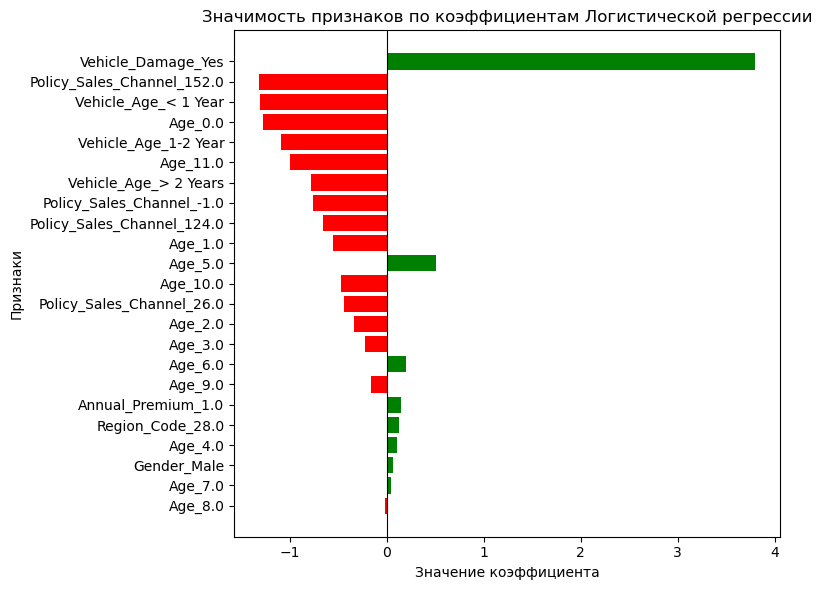

In [246]:
features_names = pipeline_logreg.named_steps["enc"].get_feature_names_out(
    input_features=X.columns
)
coefficients = pipeline_logreg.named_steps["clf"].coef_.flatten()

abs_coefficients = np.abs(coefficients)
sorted_indices = np.argsort(abs_coefficients)

ypos = np.arange(len(features_names))
sorted_features = np.array(features_names)[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

colors = ["green" if coef > 0 else "red" for coef in sorted_coefficients]

plt.figure(figsize=(8, 6))
plt.barh(ypos, sorted_coefficients, color=colors)
plt.axvline(0, color="black", linewidth=0.8)  # Линия для нуля
plt.xlabel("Значение коэффициента")
plt.ylabel("Признаки")
plt.yticks(ypos, sorted_features)
plt.title("Значимость признаков по коэффициентам Логистической регрессии")
plt.tight_layout()
plt.show()

Результаты можно проинтерпретировать следующим образом...  
Клиенты с авто после ДТП вероятнее купят страховку (ранее уже отмечалось).  
Наблюдается неудачный канал продаж - 152, который снижает вероятность покупки страховки.  
Также как ранее отмечалось, самые молодые клиенты вероятнее не будут покупать страховку.  
Большинство предикторов понижают вероятность покупки страховки.

# Обучение и валидация модели дерева решений

In [247]:
target_encoded_feature = "Age"

one_hot_encoded_features = [
    "Gender",
    "Region_Code",
    "Vehicle_Age",
    "Vehicle_Damage",
    "Annual_Premium",
    "Policy_Sales_Channel",
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "target_enc",
            TargetEncoder(target_type="binary", random_state=RANDOM_STATE),
            [target_encoded_feature],
        ),
        (
            "one_hot_enc",
            OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
            one_hot_encoded_features,
        ),
    ]
)

pipeline_dt = Pipeline(
    steps=[("preprocessing", preprocessor), ("clf", DecisionTreeClassifier())]
)

pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('target_enc',
                                                  TargetEncoder(random_state=101,
                                                                target_type='binary'),
                                                  ['Age']),
                                                 ('one_hot_enc',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Region_Code',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel'])])),
                ('clf', DecisionTreeClassifier())])

Проверим качество модели на валидационном наборе:

In [248]:
predictions_dt = pipeline_dt.predict(X_val)
print(classification_report(y_val, predictions_dt))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     62700
           1       0.37      0.02      0.04      8758

    accuracy                           0.88     71458
   macro avg       0.63      0.51      0.49     71458
weighted avg       0.82      0.88      0.82     71458



Дерево решений немного лучше классифицирует объекты положительного класса (recall=0.02).  
Метрика f1_macro повысилась до 0.49 (у логистической регресии было 0.47).

Попробуем подобрать более оптимальный порог по вероятности.

In [249]:
predictions_dt_proba = pipeline_dt.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.5, 50)
best_threshold_dt, best_f1_dt = optimize_threshold(
    y_val, predictions_dt_proba, thresholds
)

print(f"Оптимальный порог по вероятности: {best_threshold_dt}")
print(f"Лучший f1-marco: {best_f1_dt}")

Оптимальный порог по вероятности: 0.2551020408163266
Лучший f1-marco: 0.6436777792611361


При пороге вероятности 0.26 удается достичь f1-marco = 0.64 (у логистической регресии было 0.65).

Проверим на кросс-валидации.

In [250]:
probabilities_cv_dt = cross_val_predict(
    pipeline_dt, X, y, cv=cv, method="predict_proba"
)[:, 1]
predictions_cv_dt = (probabilities_cv_dt >= best_threshold_dt).astype(int)

print(f"Метрика на кросс-валидации: {f1_score(y, predictions_cv_dt, average='macro')}")

Метрика на кросс-валидации: 0.6465481649413648


На кросс-валидации получаем схожий результат с логистической регрессией - f1_marco = 0.65.

Посмотрим на важности признаков из модели дерева решений.

In [251]:
def feature_importance_plotter(model, features_names):

    feature_importance = model.feature_importances_ / np.sum(model.feature_importances_)

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig = plt.figure(figsize=(8, 4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0, 1])
    plt.ylabel("Признаки")
    plt.xlabel("Значимость")
    plt.yticks(ypos, features_names[sorted]);

Text(0.5, 1.0, 'Значимость признаков дерева решений')

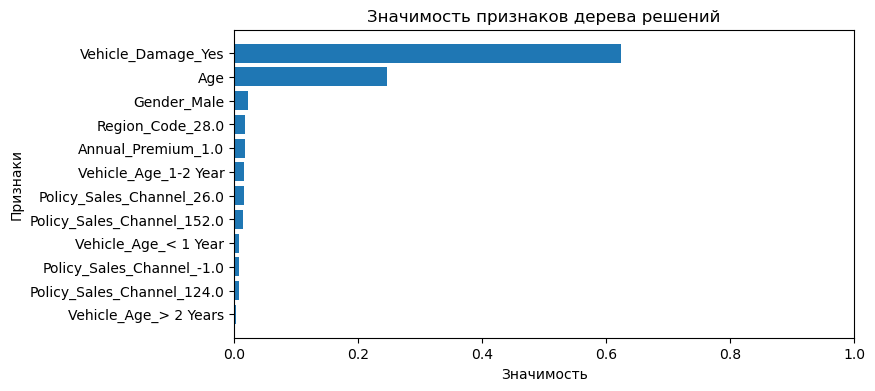

In [252]:
features_names = [target_encoded_feature] + list(
    pipeline_dt.named_steps["preprocessing"]["one_hot_enc"].get_feature_names_out(
        one_hot_encoded_features
    )
)
feature_importance_plotter(pipeline_dt.named_steps["clf"], np.array(features_names))
plt.title("Значимость признаков дерева решений")

Самым важным признаком ожидаемо является наличие повреждений у авто.  
Вторым по значимости является возраст клиента.

Выполним поиск оптимальных гиперпараметров дерева решений.

In [975]:
def objective_dt(trial):
    params = {
        "clf__max_depth": trial.suggest_int("max_depth", 1, 30),
        "clf__min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "clf__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "clf__max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "clf__class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", None]
        ),
        "clf__random_state": RANDOM_STATE,
    }

    threshold_dt = trial.suggest_float("threshold_dt", 0.1, 0.9, step=0.1)

    pipeline_dt_ = clone(pipeline_dt)
    pipeline_dt_.set_params(**params)

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    probabilities_cv_dt = cross_val_predict(
        pipeline_dt_, X, y, cv=cv, method="predict_proba"
    )[:, 1]

    predictions_cv_dt = (probabilities_cv_dt >= threshold_dt).astype(int)

    score = f1_score(y, predictions_cv_dt, average="macro")

    return score

In [ ]:
study_dt = optuna.create_study(
    direction="maximize",
    study_name="study_dt",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner(),
)
study_dt.optimize(objective_dt, n_trials=300, n_jobs=-1)

In [979]:
study_dt.best_value

0.6433965771496853

In [ ]:
best_params_dt = study_dt.best_params
best_params_dt

Поиск оптимальных гиперпараметров не позволил улучшить значение метрики.

Обучим модель на всем наборе данных и выполним предсказания на тестовом наборе.

In [253]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, threshold=0.5):
        self.classifier = classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.classifier.fit(X, y)
        return self

    def predict(self, X):
        proba = self.classifier.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.classifier.predict_proba(X)


preprocessor = ColumnTransformer(
    transformers=[
        (
            "target_enc",
            TargetEncoder(target_type="binary", random_state=RANDOM_STATE),
            ["Age"],
        ),
        (
            "one_hot_enc",
            OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
            [
                "Gender",
                "Region_Code",
                "Vehicle_Age",
                "Vehicle_Damage",
                "Annual_Premium",
                "Policy_Sales_Channel",
            ],
        ),
    ],
    remainder="drop",
)

feature_creator = ColumnTransformer(
    transformers=[
        (
            "discretizer",
            KBinsDiscretizer(n_bins=12, encode="ordinal", strategy="quantile"),
            ["Age"],
        ),
        ("binarizer", Binarizer(threshold=1e4), ["Annual_Premium"]),
    ],
    remainder="passthrough",
)


def feature_transformer(X):
    X_ = X.copy()
    X_.loc[X_["Region_Code"] != 28, "Region_Code"] = "other"
    X_.loc[
        ~(X_["Policy_Sales_Channel"].isin([152, 26, 124])), "Policy_Sales_Channel"
    ] = "other"
    X_ = X_.replace({"other": -1})
    X_transformed = feature_creator.fit_transform(X_)
    X_transformed_df = pd.DataFrame(
        X_transformed,
        columns=[
            "Age",
            "Annual_Premium",
            "id",
            "Gender",
            "Driving_License",
            "Region_Code",
            "Previously_Insured",
            "Vehicle_Age",
            "Vehicle_Damage",
            "Policy_Sales_Channel",
            "Vintage",
        ],
    )
    print(X_transformed_df.columns)
    return X_transformed_df


feature_transformer_ = FunctionTransformer(feature_transformer, validate=False)

clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

final_pipeline = Pipeline(
    steps=[
        ("feature_transformation", feature_transformer_),
        ("preprocessing", preprocessor),
        (
            "clf",
            ThresholdClassifier(classifier=clf, threshold=best_threshold_dt),
        ),
    ]
)

In [254]:
train_df, test_df = train_test_split(
    data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data[TARGET_NAME]
)

X_train = train_df.drop(columns=TARGET_NAME)
y_train = train_df[TARGET_NAME]

X_test = test_df.drop(columns=TARGET_NAME)
y_test = test_df[TARGET_NAME]

In [255]:
final_pipeline.fit(X_train, y_train)

Index(['Age', 'Annual_Premium', 'id', 'Gender', 'Driving_License',
       'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


Pipeline(steps=[('feature_transformation',
                 FunctionTransformer(func=<function feature_transformer at 0x000002BBF11DC720>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('target_enc',
                                                  TargetEncoder(random_state=101,
                                                                target_type='binary'),
                                                  ['Age']),
                                                 ('one_hot_enc',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Region_Code',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel'])])),
                ('clf',
                 ThresholdClassifier(classifier=DecisionTreeClassifier(random_state=101),
                                     threshold=0.2551020408163266))])

In [256]:
test_pred = final_pipeline.predict(X_test)

Index(['Age', 'Annual_Premium', 'id', 'Gender', 'Driving_License',
       'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


Отчет с метриками для предсказаний на тестовом наборе данных.

In [257]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     83600
           1       0.32      0.61      0.42     11678

    accuracy                           0.79     95278
   macro avg       0.63      0.71      0.65     95278
weighted avg       0.86      0.79      0.82     95278



Посмотрим на матрицу ошибок.

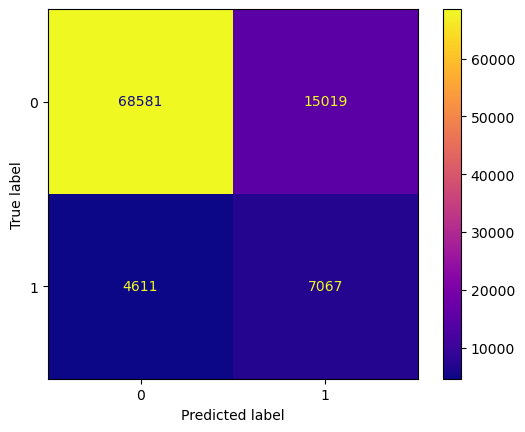

In [258]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, cmap="plasma")

Видим, что модель получалась более менее чувствительная, она верно классифицирует 84% наблюдений положительного класса.  
Но при этом специфичность у модели хромает, 29% процентов наблюдений нулевого класса она предсказывает как положительный класс.

Проанализируем значимость признаков.

In [259]:
features_names = list(
    final_pipeline.named_steps["preprocessing"]
    .named_transformers_["target_enc"]
    .get_feature_names_out()
) + list(
    final_pipeline.named_steps["preprocessing"]
    .named_transformers_["one_hot_enc"]
    .get_feature_names_out()
)

In [260]:
features_names

['Age',
 'Gender_Male',
 'Region_Code_28.0',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Age_> 2 Years',
 'Vehicle_Damage_Yes',
 'Annual_Premium_1.0',
 'Policy_Sales_Channel_-1.0',
 'Policy_Sales_Channel_26.0',
 'Policy_Sales_Channel_124.0',
 'Policy_Sales_Channel_152.0']

Text(0.5, 1.0, 'Значимость признаков дерева решений')

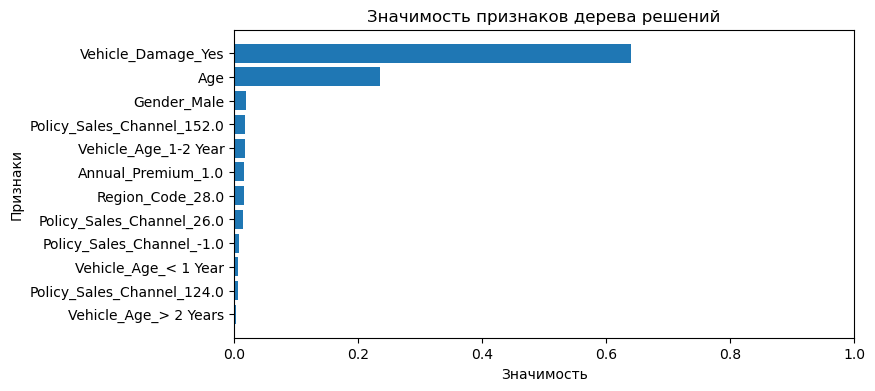

In [261]:
feature_importance_plotter(
    final_pipeline.named_steps["clf"].classifier, np.array(features_names)
)
plt.title("Значимость признаков дерева решений")

Наиболее значимыми для модели оказались признаки: наличие повреждений у авто и возраст клиента (как и раньше).

Посмотрим в разрезе признаков, для каких категорий клиентов модель больше ошибается.

In [262]:
test_df["Correct"] = (y_test == test_pred).astype(int)

Text(0.5, 1.0, 'Средние возраста клиентов, для которых модель выдает верные предсказания и для которых ошибается')

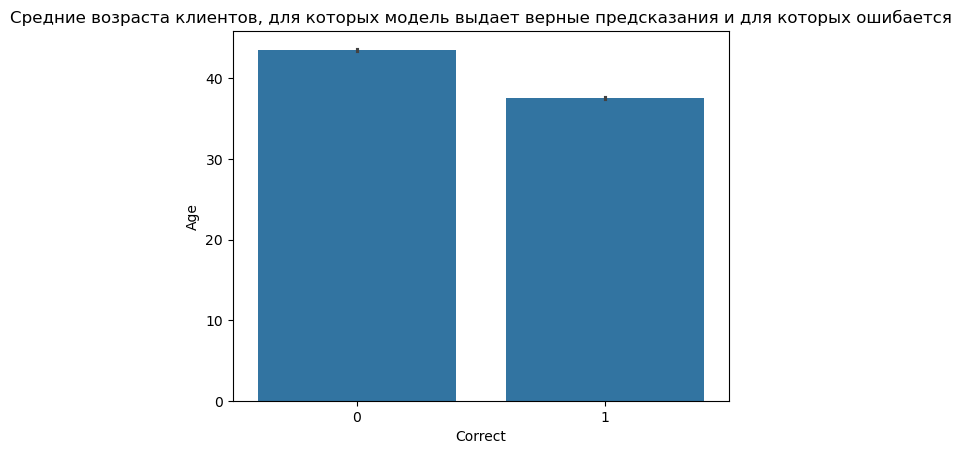

In [263]:
sns.barplot(data=test_df, y="Age", x="Correct").set_title(
    "Средние возраста клиентов, для которых модель выдает верные предсказания и для которых ошибается"
)

In [264]:
test_df.groupby("Correct")["Age"].mean()

Correct
0    43.529699
1    37.604312
Name: Age, dtype: float64

Получаем, что в среднем для клиентов помладше модель выдает верные предсказания (средний возраст данных клиентов 38 лет),  
а для клиентов постарше модель ошибается (средний возраст данных клиентов 44 года).

In [265]:
test_df.groupby("Vehicle_Damage")["Correct"].value_counts(normalize=True)

Vehicle_Damage  Correct
No              1          0.994155
                0          0.005845
Yes             1          0.597253
                0          0.402747
Name: proportion, dtype: float64

Так же можно заметить, что для авто без повреждений доля ошибок модели составляет менее 1%.  
А для авто с повреждениями модель ошибается гораздо чаще -  в 40% случаев.